In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%pwd

'g:\\Python Codes\\Text Summarizer\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'g:\\Python Codes\\Text Summarizer'

In [5]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataValidationConfig:
    root_dir: Path
    STATUS_FILE: str
    ALL_REQUIRED_FILES: list

In [6]:
from textSummarizer.constants import *
from textSummarizer.utils.common import read_yaml, create_directories

In [7]:
class ConfigurationManager:
    def __init__(
            self,
            config_filepath=CONFIG_FILE_PATH,
            params_filepath=PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_validation_config(self) -> DataValidationConfig:
        config = self.config.data_validation

        create_directories([config.root_dir])

        data_validation_config = DataValidationConfig(
            root_dir=config.root_dir,
            STATUS_FILE=config.STATUS_FILE,
            ALL_REQUIRED_FILES=config.ALL_REQUIRED_FILES,
        )

        return data_validation_config

In [8]:
import os
from textSummarizer.logging import logger

In [ ]:
import os
from textSummarizer.logging import logger
from pathlib import Path
from datasets import load_from_disk
import pandas as pd
import numpy as np
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt

class DataValidation:
    def __init__(self, config: DataValidationConfig):  
        self.config = config

[2026-01-26 19:40:11,484: INFO: utils: NumExpr defaulting to 12 threads.]


c:\Users\USER\anaconda3\envs\textsum\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def validate_all_files_exist(self) -> bool:
    try:
        validation_status = True  # Start as True; set to False if any issue
        all_files = os.listdir(os.path.join(
            "artifacts", "data_ingestion", "samsum_dataset"))

        for required_file in self.config.ALL_REQUIRED_FILES:
            if required_file not in all_files:
                validation_status = False
                logger.error(
                    f"Missing required file/directory: {required_file}")
                break  # Stop checking further once a missing file is found

        with open(self.config.STATUS_FILE, "w") as f:
            f.write(f"File existence validation status: {validation_status}")
        return validation_status
    except Exception as e:
        logger.error(f"Error during file existence validation: {e}")
        raise e

In [11]:
def validate_directories_not_empty(self) -> bool:
    try:
        status = True
        base_path = Path("artifacts/data_ingestion/samsum_dataset")
        for item in self.config.ALL_REQUIRED_FILES:
            item_path = base_path / item
            if item_path.is_dir():
                if not any(item_path.iterdir()):  # Check if directory is empty
                    logger.error(f"Directory {item} is empty")
                    status = False
            elif item_path.is_file():
                if item_path.stat().st_size == 0:  # Check if file is empty
                    logger.error(f"File {item} is empty")
                    status = False
        with open(self.config.STATUS_FILE, "a") as f:
            f.write(f"\nDirectory emptiness validation status: {status}")
        return status
    except Exception as e:
        logger.error(f"Error during directory emptiness validation: {e}")
        raise e

In [12]:
def validate_dataset_structure(self) -> bool:
    try:
        dataset_path = Path("artifacts/data_ingestion/samsum_dataset")
        if not dataset_path.exists():
            logger.error("Dataset path does not exist")
            return False

        dataset = load_from_disk(str(dataset_path))
        required_columns = ['dialogue', 'summary', 'id']

        for split in ['train', 'test', 'validation']:
            if split not in dataset:
                logger.error(f"Missing split: {split}")
                return False
            sample = dataset[split].select(
                range(min(5, len(dataset[split]))))  # Check first 5 samples
            for col in required_columns:
                if col not in sample.column_names:
                    logger.error(f"Missing column '{col}' in {split} split")
                    return False

        logger.info("Dataset structure validation passed")
        with open(self.config.STATUS_FILE, "a") as f:
            f.write(f"\nDataset structure validation status: True")
        return True
    except Exception as e:
        logger.error(f"Error during dataset structure validation: {e}")
        with open(self.config.STATUS_FILE, "a") as f:
            f.write(f"\nDataset structure validation status: False")
        raise e

In [13]:
def validate_data_quality(self) -> bool:
    try:
        dataset_path = Path("artifacts/data_ingestion/samsum_dataset")
        dataset = load_from_disk(str(dataset_path))
        status = True

        for split in ['train', 'test', 'validation']:
            df = pd.DataFrame(dataset[split])

            # Check for missing values in required columns
            for col in ['dialogue', 'summary']:
                if df[col].isnull().any():
                    logger.error(f"Missing values in {col} for {split} split")
                    status = False

            # Check for duplicates
            if df.duplicated(subset=['dialogue', 'summary']).any():
                logger.error(f"Duplicate entries found in {split} split")
                status = False

            # Check text lengths (basic sanity)
            if (df['dialogue'].str.len() < 10).any() or (df['summary'].str.len() < 5).any():
                logger.error(f"Unusually short text in {split} split")
                status = False

        with open(self.config.STATUS_FILE, "a") as f:
            f.write(f"\nData quality validation status: {status}")
        return status
    except Exception as e:
        logger.error(f"Error during data quality validation: {e}")
        raise e

In [14]:
def validate_data_consistency(self) -> bool:
    try:
        dataset_path = Path("artifacts/data_ingestion/samsum_dataset")
        dataset = load_from_disk(str(dataset_path))
        status = True

        # Check column consistency across splits
        train_cols = set(dataset['train'].column_names)
        for split in ['test', 'validation']:
            split_cols = set(dataset[split].column_names)
            if train_cols != split_cols:
                logger.error(f"Column mismatch in {split} split")
                status = False

        # Check data types
        for split in ['train', 'test', 'validation']:
            for col in ['dialogue', 'summary']:
                if not pd.api.types.is_string_dtype(dataset[split][col]):
                    logger.error(f"Column {col} in {split} is not string type")
                    status = False

        with open(self.config.STATUS_FILE, "a") as f:
            f.write(f"\nData consistency validation status: {status}")
        return status
    except Exception as e:
        logger.error(f"Error during data consistency validation: {e}")
        raise e

In [15]:
def validate_split_sizes(self) -> bool:
    try:
        dataset_path = Path("artifacts/data_ingestion/samsum_dataset")
        dataset = load_from_disk(str(dataset_path))
        status = True

        # Basic size checks (adjust thresholds as needed)
        if len(dataset['train']) < 1000:
            logger.error("Train split too small")
            status = False
        if len(dataset['test']) < 100:
            logger.error("Test split too small")
            status = False
        if len(dataset['validation']) < 100:
            logger.error("Validation split too small")
            status = False

        with open(self.config.STATUS_FILE, "a") as f:
            f.write(f"\nSplit sizes validation status: {status}")
        return status
    except Exception as e:
        logger.error(f"Error during split sizes validation: {e}")
        raise e

In [16]:
def validate_data_statistics(self) -> bool:
    try:
        dataset_path = Path("artifacts/data_ingestion/samsum_dataset")
        dataset = load_from_disk(str(dataset_path))
        status = True

        for split in ['train', 'test', 'validation']:
            df = pd.DataFrame(dataset[split])

            # Compute text lengths
            df['dialogue_len'] = df['dialogue'].str.len()
            df['summary_len'] = df['summary'].str.len()

            # Basic statistics
            dialogue_stats = df['dialogue_len'].describe()
            summary_stats = df['summary_len'].describe()

            logger.info(
                f"{split} Dialogue length stats: {dialogue_stats.to_dict()}")
            logger.info(
                f"{split} Summary length stats: {summary_stats.to_dict()}")

            # Check for outliers using IQR
            for col, name in [('dialogue_len', 'dialogue'), ('summary_len', 'summary')]:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) |
                              (df[col] > upper_bound)]
                if len(outliers) > len(df) * 0.05:  # More than 5% outliers
                    logger.warning(
                        f"High number of outliers in {name} lengths for {split}: {len(outliers)}")
                    # Not failing, just warning

            # Check summary not longer than dialogue (basic sanity for summarization)
            if (df['summary_len'] > df['dialogue_len']).any():
                logger.warning(
                    f"Some summaries longer than dialogues in {split}")

            # Vocabulary size (unique words)
            all_text = ' '.join(
                df['dialogue'].tolist() + df['summary'].tolist())
            vocab_size = len(set(all_text.split()))
            logger.info(f"{split} Approximate vocabulary size: {vocab_size}")
            if vocab_size < 1000:
                logger.error(f"Vocabulary too small for {split}")
                status = False

            # N-gram analysis
            all_text_lower = all_text.lower()
            words = all_text_lower.split()

            # Bigrams
            bigrams = list(ngrams(words, 2))
            bigram_freq = Counter(bigrams)
            top_bigrams = bigram_freq.most_common(10)
            logger.info(f"{split} Top 10 bigrams: {top_bigrams}")

            # Trigrams
            trigrams = list(ngrams(words, 3))
            trigram_freq = Counter(trigrams)
            top_trigrams = trigram_freq.most_common(10)
            logger.info(f"{split} Top 10 trigrams: {top_trigrams}")

            # N-gram diversity
            unique_bigrams = len(bigram_freq)
            total_bigrams = len(bigrams)
            diversity_ratio = unique_bigrams / total_bigrams if total_bigrams > 0 else 0
            logger.info(
                f"{split} Bigram diversity ratio: {diversity_ratio:.4f}")
            if diversity_ratio < 0.1:  # Arbitrary threshold for low diversity
                logger.warning(
                    f"Low bigram diversity in {split}, possible repetitive text")

            # Visualizations
            os.makedirs("artifacts/data_validation/plots", exist_ok=True)

            plt.figure(figsize=(15, 5))

            # 1. Histograms/Box plots for text length distributions
            plt.subplot(1, 3, 1)
            plt.hist(df['dialogue_len'], bins=50, alpha=0.7, label='Dialogue')
            plt.hist(df['summary_len'], bins=50, alpha=0.7, label='Summary')
            plt.title(f'{split} Text Length Histogram')
            plt.xlabel('Length')
            plt.ylabel('Frequency')
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.boxplot([df['dialogue_len'], df['summary_len']],
                        labels=['Dialogue', 'Summary'])
            plt.title(f'{split} Text Length Box Plot')
            plt.ylabel('Length')

            # 2. Bar chart for top n-grams (using bigrams)
            plt.subplot(1, 3, 3)
            ngram_labels = [f"{bg[0]} {bg[1]}" for bg, _ in top_bigrams]
            ngram_counts = [count for _, count in top_bigrams]
            plt.barh(ngram_labels, ngram_counts)
            plt.title(f'{split} Top 10 Bigrams')
            plt.xlabel('Frequency')

            plt.tight_layout()
            plt.savefig(
                f"artifacts/data_validation/plots/{split}_lengths_ngrams.png")
            plt.show()

            # 3. Scatter plot for length correlations
            plt.figure()
            plt.scatter(df['dialogue_len'], df['summary_len'], alpha=0.5)
            plt.title(f'{split} Dialogue vs Summary Length Correlation')
            plt.xlabel('Dialogue Length')
            plt.ylabel('Summary Length')
            plt.savefig(
                f"artifacts/data_validation/plots/{split}_correlation.png")
            plt.show()

        with open(self.config.STATUS_FILE, "a") as f:
            f.write(f"\nData statistics validation status: {status}")
        return status
    except Exception as e:
        logger.error(f"Error during data statistics validation: {e}")
        raise e

In [17]:
def initiate_data_validation(self) -> None:
    try:
        status1 = self.validate_all_files_exist()
        status2 = self.validate_directories_not_empty()
        status3 = self.validate_dataset_structure()
        status4 = self.validate_data_quality()
        status5 = self.validate_data_consistency()
        status6 = self.validate_split_sizes()
        status7 = self.validate_data_statistics()

        overall_status = status1 and status2 and status3 and status4 and status5 and status6 and status7
        if overall_status:
            logger.info("All data validations passed")
        else:
            logger.error("Data validation failed")

        with open(self.config.STATUS_FILE, "a") as f:  # Append to avoid overwriting
            f.write(f"\nOverall validation status: {overall_status}")
    except Exception as e:
        logger.error(f"Error during data validation: {e}")
        raise e

In [18]:
DataValidation.validate_all_files_exist = validate_all_files_exist
DataValidation.validate_directories_not_empty = validate_directories_not_empty
DataValidation.validate_dataset_structure = validate_dataset_structure
DataValidation.validate_data_quality = validate_data_quality
DataValidation.validate_data_consistency = validate_data_consistency
DataValidation.validate_split_sizes = validate_split_sizes
DataValidation.validate_data_statistics = validate_data_statistics
DataValidation.initiate_data_validation = initiate_data_validation

Current directory: g:\Python Codes\Text Summarizer
Config path: config\config.yaml
[2026-01-26 19:40:15,842: INFO: common: yaml file: config\config.yaml loaded successfully]
[2026-01-26 19:40:15,844: INFO: common: yaml file: params.yaml loaded successfully]
[2026-01-26 19:40:15,845: INFO: common: created directory at: artifacts]
[2026-01-26 19:40:15,847: INFO: common: created directory at: artifacts/data_validation]
[2026-01-26 19:40:15,977: INFO: 627638535: Dataset structure validation passed]
[2026-01-26 19:40:16,456: ERROR: 2841408004: Duplicate entries found in train split]
[2026-01-26 19:40:16,462: ERROR: 2841408004: Unusually short text in train split]
[2026-01-26 19:40:16,523: ERROR: 3802380581: Column dialogue in train is not string type]
[2026-01-26 19:40:16,524: ERROR: 3802380581: Column summary in train is not string type]
[2026-01-26 19:40:16,525: ERROR: 3802380581: Column dialogue in test is not string type]
[2026-01-26 19:40:16,526: ERROR: 3802380581: Column summary in te

C:\Users\USER\AppData\Local\Temp\ipykernel_23344\340552411.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['dialogue_len'], df['summary_len']],


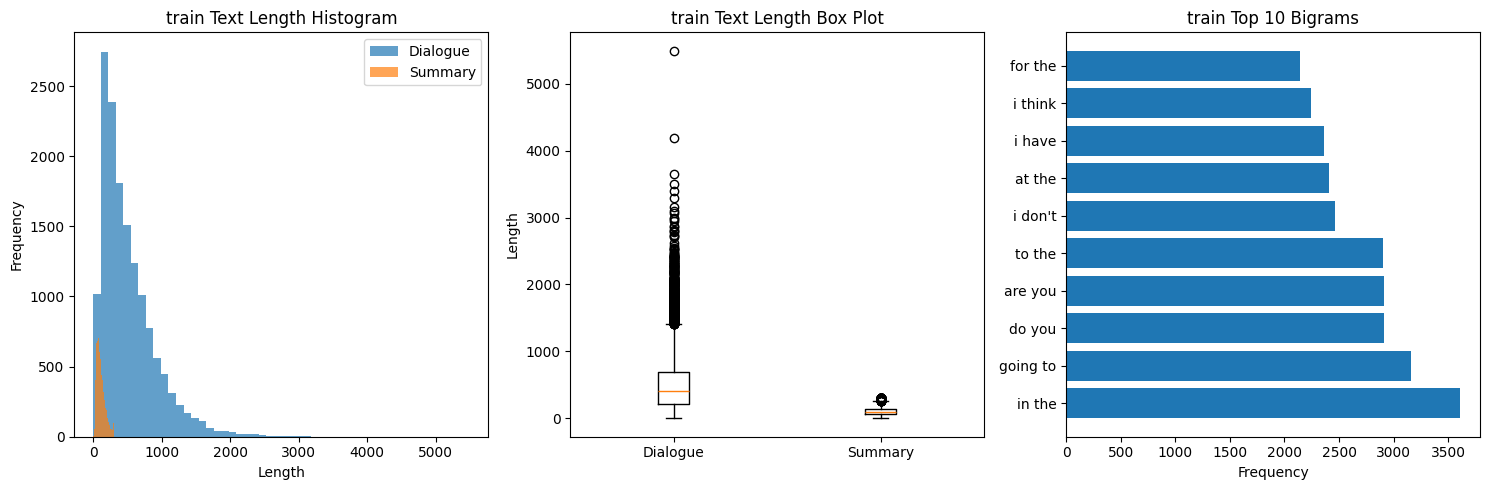

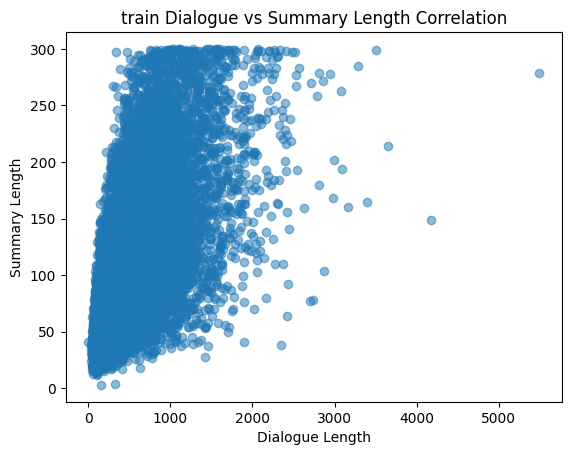

[2026-01-26 19:40:19,851: INFO: 340552411: test Dialogue length stats: {'count': 819.0, 'mean': 521.5982905982906, 'std': 409.38732450341814, 'min': 49.0, '25%': 226.0, '50%': 403.0, '75%': 687.5, 'max': 2793.0}]
[2026-01-26 19:40:19,851: INFO: 340552411: test Summary length stats: {'count': 819.0, 'mean': 108.78021978021978, 'std': 58.46138925558024, 'min': 17.0, '25%': 63.0, '50%': 96.0, '75%': 142.0, 'max': 300.0}]
[2026-01-26 19:40:19,858: WARNING: 340552411: Some summaries longer than dialogues in test]
[2026-01-26 19:40:19,876: INFO: 340552411: test Approximate vocabulary size: 14221]
[2026-01-26 19:40:19,971: INFO: 340552411: test Top 10 bigrams: [(('in', 'the'), 207), (('to', 'the'), 164), (('going', 'to'), 164), (('are', 'you'), 161), (('do', 'you'), 158), (('i', "don't"), 151), (('i', 'have'), 132), (('have', 'a'), 121), (('for', 'the'), 117), (('will', 'be'), 115)]]
[2026-01-26 19:40:20,067: INFO: 340552411: test Top 10 trigrams: [(('a', 'lot', 'of'), 41), (('are', 'going', 

C:\Users\USER\AppData\Local\Temp\ipykernel_23344\340552411.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['dialogue_len'], df['summary_len']],


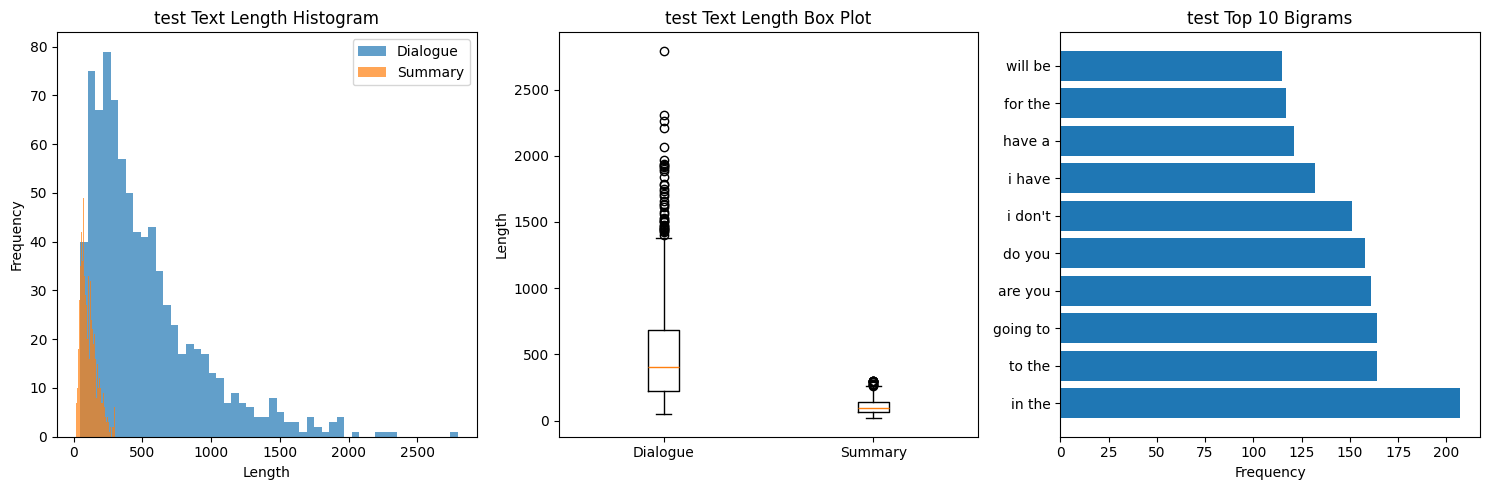

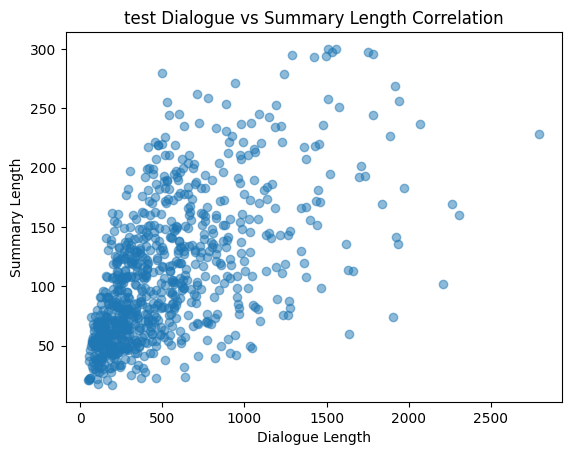

[2026-01-26 19:40:20,876: INFO: 340552411: validation Dialogue length stats: {'count': 818.0, 'mean': 499.3960880195599, 'std': 403.63258385677415, 'min': 57.0, '25%': 208.0, '50%': 385.5, '75%': 688.0, 'max': 2950.0}]
[2026-01-26 19:40:20,877: INFO: 340552411: validation Summary length stats: {'count': 818.0, 'mean': 110.17481662591688, 'std': 61.388822409264314, 'min': 17.0, '25%': 63.0, '50%': 96.0, '75%': 144.0, 'max': 300.0}]
[2026-01-26 19:40:20,891: INFO: 340552411: validation Approximate vocabulary size: 13683]
[2026-01-26 19:40:20,940: INFO: 340552411: validation Top 10 bigrams: [(('in', 'the'), 227), (('to', 'the'), 192), (('do', 'you'), 186), (('are', 'you'), 161), (('going', 'to'), 156), (('i', 'have'), 136), (('i', "don't"), 125), (('at', 'the'), 124), (('will', 'be'), 122), (('for', 'the'), 115)]]
[2026-01-26 19:40:20,976: INFO: 340552411: validation Top 10 trigrams: [(('what', 'do', 'you'), 43), (('go', 'to', 'the'), 37), (('going', 'to', 'the'), 37), (('are', 'going', '

C:\Users\USER\AppData\Local\Temp\ipykernel_23344\340552411.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['dialogue_len'], df['summary_len']],


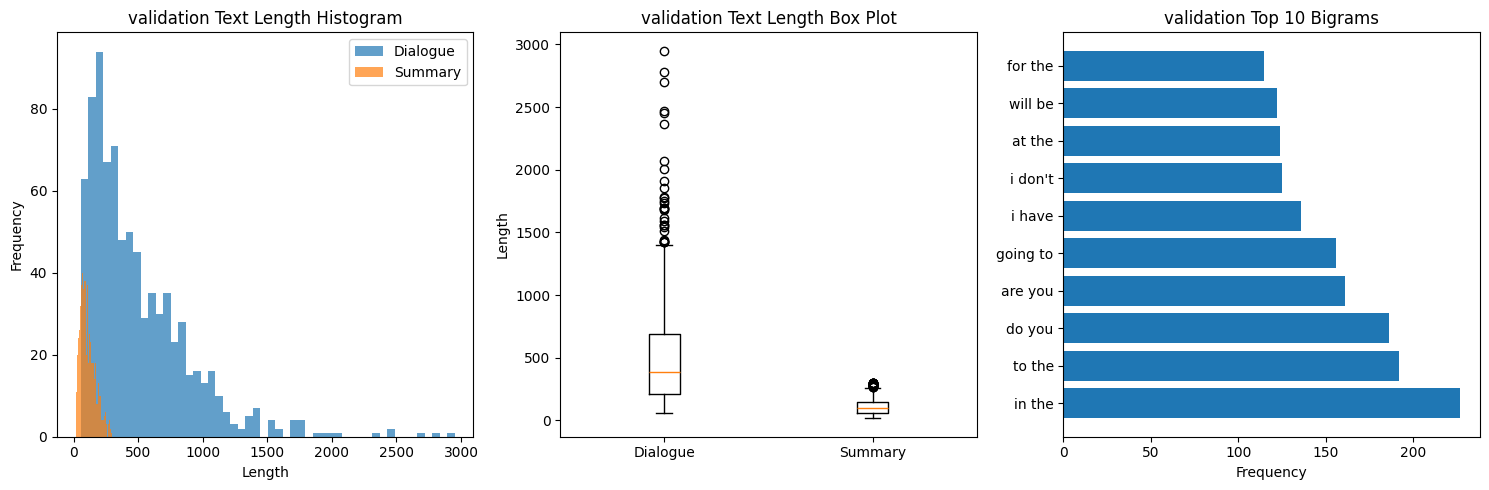

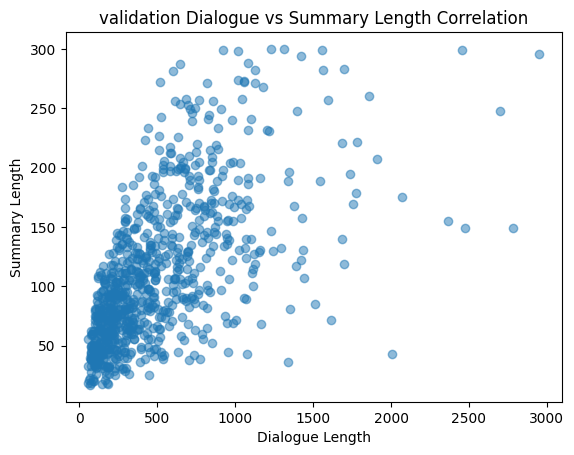

[2026-01-26 19:40:21,643: ERROR: 719434905: Data validation failed]


In [19]:
os.chdir(r"g:\Python Codes\Text Summarizer")
print(f"Current directory: {os.getcwd()}")
print(f"Config path: {CONFIG_FILE_PATH}")
config_manager = ConfigurationManager()
config = config_manager.get_data_validation_config()
validator = DataValidation(config)
validator.initiate_data_validation()

[2026-01-26 19:40:21,654: INFO: common: yaml file: config\config.yaml loaded successfully]
[2026-01-26 19:40:21,656: INFO: common: yaml file: params.yaml loaded successfully]
[2026-01-26 19:40:21,657: INFO: common: created directory at: artifacts]
[2026-01-26 19:40:21,658: INFO: common: created directory at: artifacts/data_validation]
[2026-01-26 19:40:22,074: INFO: 340552411: train Dialogue length stats: {'count': 14732.0, 'mean': 511.18361390171054, 'std': 402.6214360842471, 'min': 0.0, '25%': 216.0, '50%': 401.0, '75%': 694.0, 'max': 5492.0}]
[2026-01-26 19:40:22,074: INFO: 340552411: train Summary length stats: {'count': 14732.0, 'mean': 110.13467282106978, 'std': 60.89247137091239, 'min': 3.0, '25%': 63.0, '50%': 96.0, '75%': 144.0, 'max': 300.0}]
[2026-01-26 19:40:22,078: WARNING: 340552411: Some summaries longer than dialogues in train]
[2026-01-26 19:40:22,277: INFO: 340552411: train Approximate vocabulary size: 80987]
[2026-01-26 19:40:23,316: INFO: 340552411: train Top 10 big

C:\Users\USER\AppData\Local\Temp\ipykernel_23344\340552411.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['dialogue_len'], df['summary_len']],


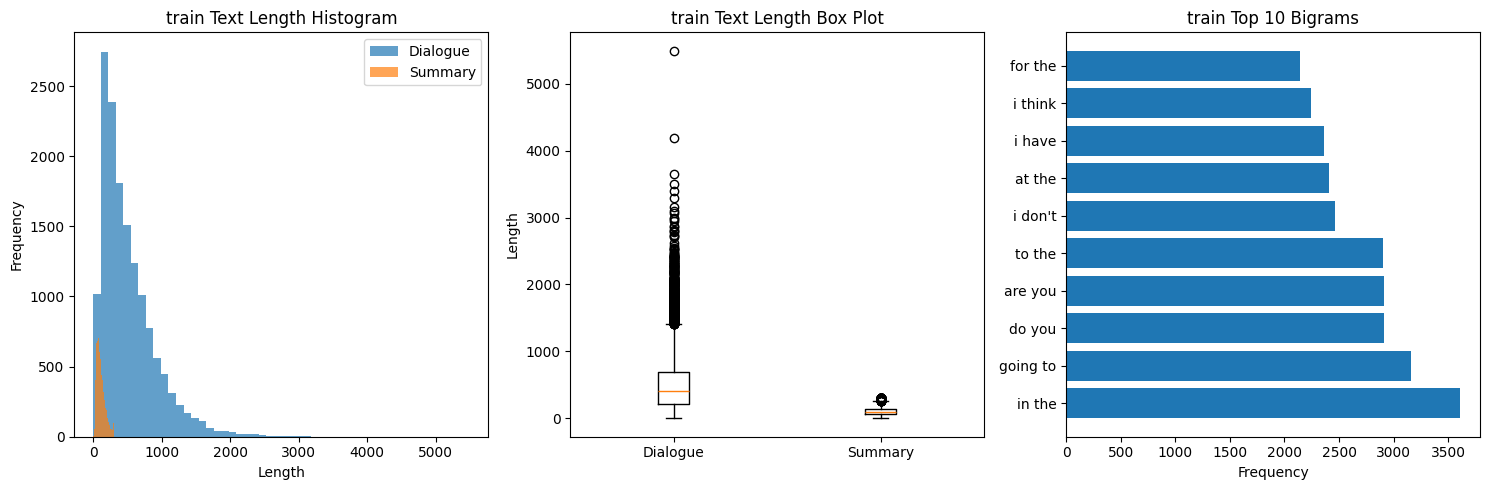

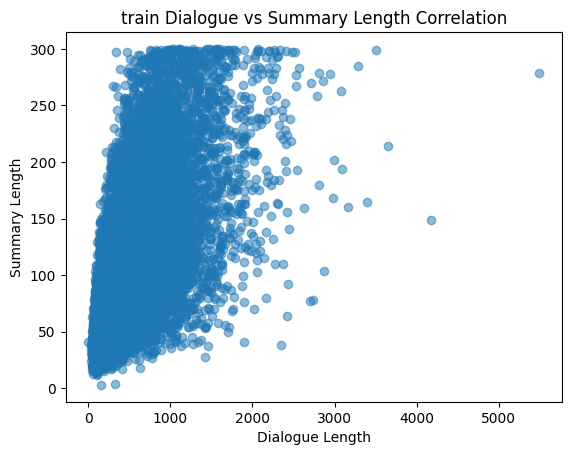

[2026-01-26 19:40:25,010: INFO: 340552411: test Dialogue length stats: {'count': 819.0, 'mean': 521.5982905982906, 'std': 409.38732450341814, 'min': 49.0, '25%': 226.0, '50%': 403.0, '75%': 687.5, 'max': 2793.0}]
[2026-01-26 19:40:25,011: INFO: 340552411: test Summary length stats: {'count': 819.0, 'mean': 108.78021978021978, 'std': 58.46138925558024, 'min': 17.0, '25%': 63.0, '50%': 96.0, '75%': 142.0, 'max': 300.0}]
[2026-01-26 19:40:25,015: WARNING: 340552411: Some summaries longer than dialogues in test]
[2026-01-26 19:40:25,028: INFO: 340552411: test Approximate vocabulary size: 14221]
[2026-01-26 19:40:25,132: INFO: 340552411: test Top 10 bigrams: [(('in', 'the'), 207), (('to', 'the'), 164), (('going', 'to'), 164), (('are', 'you'), 161), (('do', 'you'), 158), (('i', "don't"), 151), (('i', 'have'), 132), (('have', 'a'), 121), (('for', 'the'), 117), (('will', 'be'), 115)]]
[2026-01-26 19:40:25,231: INFO: 340552411: test Top 10 trigrams: [(('a', 'lot', 'of'), 41), (('are', 'going', 

C:\Users\USER\AppData\Local\Temp\ipykernel_23344\340552411.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['dialogue_len'], df['summary_len']],


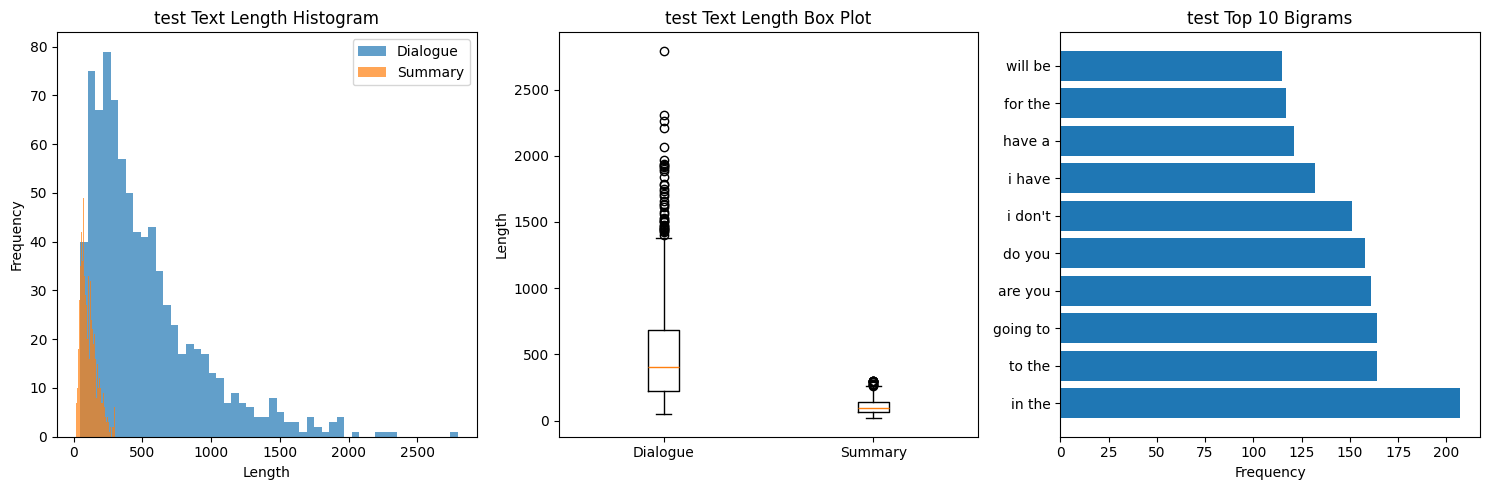

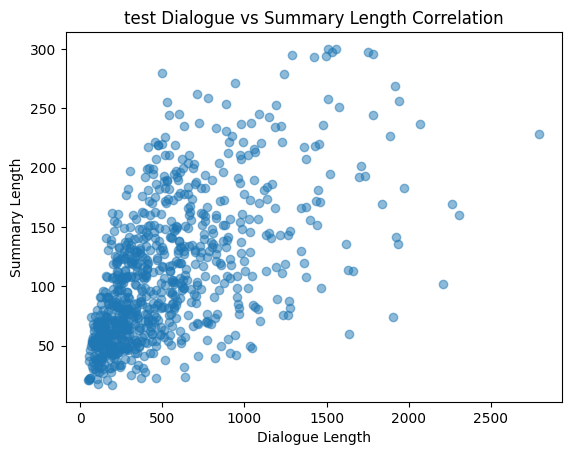

[2026-01-26 19:40:25,921: INFO: 340552411: validation Dialogue length stats: {'count': 818.0, 'mean': 499.3960880195599, 'std': 403.63258385677415, 'min': 57.0, '25%': 208.0, '50%': 385.5, '75%': 688.0, 'max': 2950.0}]
[2026-01-26 19:40:25,922: INFO: 340552411: validation Summary length stats: {'count': 818.0, 'mean': 110.17481662591688, 'std': 61.388822409264314, 'min': 17.0, '25%': 63.0, '50%': 96.0, '75%': 144.0, 'max': 300.0}]
[2026-01-26 19:40:25,940: INFO: 340552411: validation Approximate vocabulary size: 13683]
[2026-01-26 19:40:26,000: INFO: 340552411: validation Top 10 bigrams: [(('in', 'the'), 227), (('to', 'the'), 192), (('do', 'you'), 186), (('are', 'you'), 161), (('going', 'to'), 156), (('i', 'have'), 136), (('i', "don't"), 125), (('at', 'the'), 124), (('will', 'be'), 122), (('for', 'the'), 115)]]
[2026-01-26 19:40:26,036: INFO: 340552411: validation Top 10 trigrams: [(('what', 'do', 'you'), 43), (('go', 'to', 'the'), 37), (('going', 'to', 'the'), 37), (('are', 'going', '

C:\Users\USER\AppData\Local\Temp\ipykernel_23344\340552411.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['dialogue_len'], df['summary_len']],


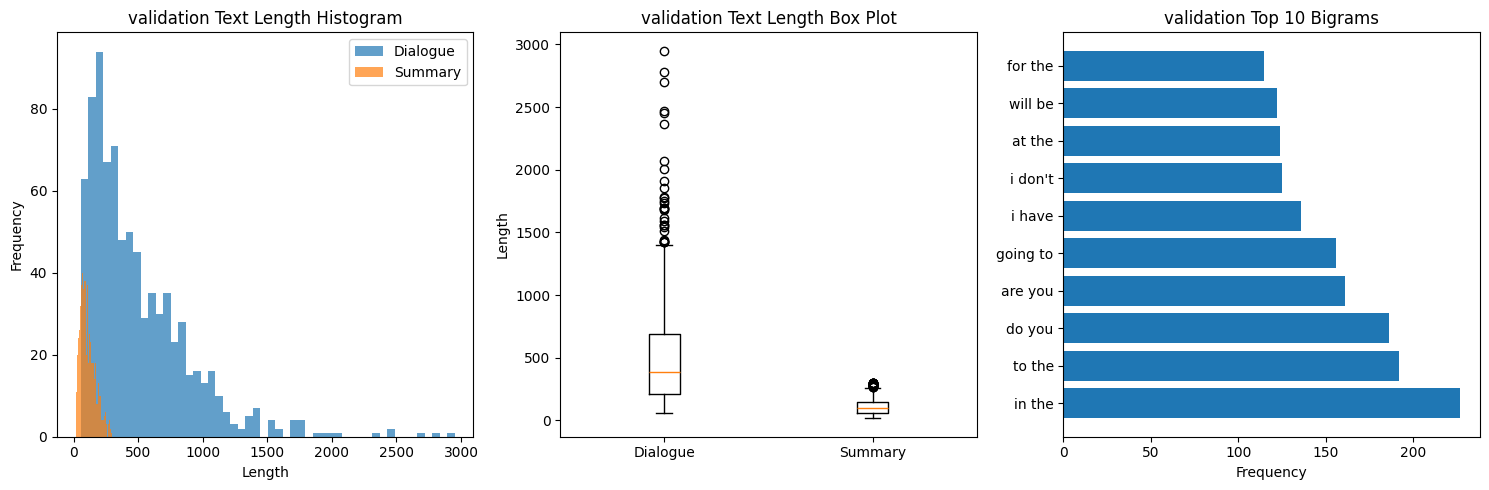

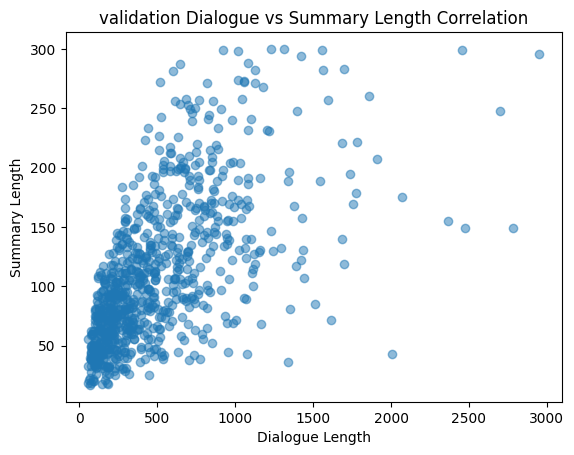

True

In [20]:
os.chdir(r"g:\Python Codes\Text Summarizer")
config_manager = ConfigurationManager()
config = config_manager.get_data_validation_config()
validator = DataValidation(config)
validator.validate_data_statistics()